## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

# Matrix Factorization

In [27]:
import time
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
%matplotlib inline

## Restaurant recommendation

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not yet rated based on a latent factor model.

Specifically, the objective function (loss) we wanted to optimize is:
$$
\mathcal{L} = \min_{P, Q} \sum_{(u, i) \in S} (R_{ui} - \mathbf{q}_u\mathbf{p}_i^T)^2 + \lambda\sum_i{\left\lVert \mathbf{p}_i  \right\rVert}^2 + \lambda\sum_u {\left\lVert\mathbf{q}_u  \right\rVert}^2
$$

where $S$ is the set of $(u, i)$ pairs for which the rating $R_{ui}$ given by user $u$ to restaurant $i$ is known. Here we have also introduced two regularization terms to help us with overfitting where $\lambda$ is hyper-parameter that control the strength of the regularization.

The task it to solve the matrix factorization via alternating least squares _and_ stochastic gradient descent (non-batched, you may omit the bias).

**Hint 1**: Using the closed form solution for regression might lead to singular values. To avoid this issue perform the regression step with an existing package such as scikit-learn. It is advisable to use ridge regression to account for regularization.

**Hint 2**: If you are using the scikit-learn package remember to set ``fit_intercept = False`` to only learn the coefficients of the linear regression.

### Load and Preprocess the Data (nothing to do here) 

In [2]:
ratings = np.load("exercise_11_matrix_factorization_ratings.npy")

In [3]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=int64)

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset. We store the data as a sparse matrix to avoid out-of-memory issues.

In [4]:
n_users = np.max(ratings[:,0] + 1)
n_restaurants = np.max(ratings[:,1] + 1)
R = sp.coo_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), shape=(n_users, n_restaurants)).tocsr()
R

<337867x5899 sparse matrix of type '<class 'numpy.int64'>'
	with 929606 stored elements in Compressed Sparse Row format>

To avoid the <a href="https://en.wikipedia.org/wiki/Cold_start_(computing)"> cold start problem</a>, in the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings.

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.

**Note**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. We store the indices for which we the rating data available in a separate variable.

In [5]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    shape = (-1, -1)
    while matrix.shape != shape:
        shape = matrix.shape
        nnz = matrix > 0
        row_ixs = nnz.sum(1).A1 > min_entries   # A1 is used to convert the matrix to 1D array
        matrix = matrix[row_ixs]
        nnz = matrix > 0
        col_ixs = nnz.sum(0).A1 > min_entries
        matrix = matrix[:, col_ixs]
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

### Task 1: Implement a function that subtracts the mean user rating from the sparse rating matrix

In [6]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    # TODO: Compute the modified matrix and user_means
    
    ## BEGIN SOLUTION
    nnz_mask = (matrix > 0) # represents the non-zero elements in the matrix
    user_means = matrix.sum(1) / nnz_mask.sum(1) #sum of all ratings per user divided by the number of ratings per user
    subtract_mask = sp.csr_matrix(user_means).multiply(nnz_mask)   #transform the user_means into a parse matrix and multiply it with the nnz_mask
    matrix = matrix-subtract_mask
    ## END SOLUTION
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

### Split the data into a train, validation and test set (nothing to do here)

In [7]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    matrix_cp = matrix.copy()
    non_zero_idx = np.argwhere(matrix_cp)
    ixs = np.random.permutation(non_zero_idx)
    val_idx = tuple(ixs[:n_validation].T)
    test_idx = tuple(ixs[n_validation:n_validation + n_test].T)
    
    val_values = matrix_cp[val_idx].A1
    test_values = matrix_cp[test_idx].A1
    
    matrix_cp[val_idx] = matrix_cp[test_idx] = 0
    matrix_cp.eliminate_zeros()

    return matrix_cp, val_idx, test_idx, val_values, test_values

In [8]:
R = cold_start_preprocessing(R, 20)

Shape before: (337867, 5899)
Shape after: (3529, 2072)


In [9]:
n_validation = 200
n_test = 200
# Split data
R_train, val_idx, test_idx, val_values, test_values = split_data(R, n_validation, n_test)   #split the data and get the validation and test indices, set the values at these indices to zero in the matr

In [10]:
# Remove user means.
nonzero_indices = np.argwhere(R_train)
R_shifted, user_means = shift_user_mean(R_train)
# Apply the same shift to the validation and test data.
val_values_shifted = val_values - np.ravel(user_means[np.array(val_idx).T[:,0]])
test_values_shifted = test_values - np.ravel(user_means[np.array(test_idx).T[:,0]])

### Compute the loss function (nothing to do here)

In [11]:
def loss(values, ixs, Q, P, reg_lambda):
    """
    Compute the loss of the latent factor model (at indices ixs).
    Parameters
    ----------
    values : np.array, shape [n_ixs,]
        The array with the ground-truth values.
    ixs : tuple, shape [2, n_ixs]
        The indices at which we want to evaluate the loss (usually the nonzero indices of the unshifted data matrix).
    Q : np.array, shape [N, k]
        The matrix Q of a latent factor model.
    P : np.array, shape [k, D]
        The matrix P of a latent factor model.
    reg_lambda : float
        The regularization strength
          
    Returns
    -------
    loss : float
           The loss of the latent factor model.

    """
    mean_sse_loss = np.sum((values - Q.dot(P)[ixs])**2)
    regularization_loss =  reg_lambda * (np.sum(np.linalg.norm(P, axis=0)**2) + np.sum(np.linalg.norm(Q, axis=1) ** 2))
    
    return mean_sse_loss + regularization_loss

## Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa.

### Task 2: Implement a function that initializes the latent factors $Q$ and $P$

In [12]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 
             'random' means we initialize the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """
    np.random.seed(0)
    
    # TODO: Compute Q and P
    
    ## BEGIN SOLUTION
    if init == 'svd':
        u, s, v = svds(matrix, k)   # s is the 1 dimensional array of singular values
        Q = u.dot(s)
        P = v
    elif init == 'random':
        Q = np.random.rand(matrix.shape[0], k)
        P = np.random.rand(k, matrix.shape[1])
    else:
        raise ValueError("init not recognized")
    ## END SOLUTION
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

### Task 3: Implement the alternating optimization approach and stochastic gradient approach

In [28]:
from scipy.sparse import csr_matrix

In [29]:
def latent_factor_alternating_optimization(R, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=5, eval_every=1, optimizer='sgd', lr=1e-2):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    R                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.
                      
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 5
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    optimizer         : str, optional, default: sgd
                        If `sgd` stochastic gradient descent shall be used. Otherwise, use alternating least squares.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
    
    # TODO: Compute best_Q, best_P, validation_losses, train_losses and converged_after
 
    # Build a sparse mask of non-zero entries from non_zero_idx
    nnz_mask = sp.coo_matrix((np.ones(len(non_zero_idx)),
                              (non_zero_idx[:, 0], non_zero_idx[:, 1])),
                             shape=R.shape, dtype="uint8").tocsr()
    # Precompute per-column and per-row nonzero indices using LIL format
    cols = nnz_mask.T.tolil().rows  # list of lists for each column (each list contains row indices)
    rows = nnz_mask.tolil().rows    # list of lists for each row (each list contains column indices)

    # Create a Ridge regressor instance for ALS updates
    reg = Ridge(alpha=reg_lambda, fit_intercept=False)
    
    # Initialize Q and P using the specified strategy
    Q, P = initialize_Q_P(R, k, init)
    
    # Precompute training indices in the expected tuple format for the loss function:
    # (array_of_row_indices, array_of_col_indices)
    train_idx = tuple(non_zero_idx.T)
    
    # Initialize containers for losses and early stopping variables
    train_losses = []
    validation_losses = []
    best_val_loss = np.inf
    best_Q = Q.copy()
    best_P = P.copy()
    current_patience = patience
    converged_after = -1
    times = []
    bef = None
    
    # Ensure that R is in CSR format for efficient row access
    R = csr_matrix(R)
    
    for it in range(max_steps):
        # Timing per iteration (optional)
        if bef is not None:
            times.append(time.time() - bef)
        bef = time.time()
        
        # Evaluate loss every eval_every iterations
        if it % eval_every == 0:
            # Compute training loss on non-zero entries
            # Here, R[train_idx].A1 converts the nonzero entries to a 1D array
            train_loss = loss(R[train_idx].A1, train_idx, Q, P, reg_lambda)
            train_losses.append(train_loss)
            
            # Compute validation loss using the provided validation indices and values
            val_loss = loss(val_values, val_idx, Q, P, reg_lambda)
            validation_losses.append(val_loss)
            
            # Update best model if validation loss improves; otherwise, reduce patience
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_Q = Q.copy()
                best_P = P.copy()
                current_patience = patience  # reset patience
            else:
                current_patience -= 1
            
            if log_every and it % log_every == 0:
                print("Iteration {}: training loss = {:.3f}, validation loss = {:.3f}".format(it, train_loss, val_loss))
            
            # Early stopping check
            if current_patience <= 0:
                converged_after = it - patience * eval_every
                print("Early stopping at iteration {}, converged after {} iterations".format(it, converged_after))
                break
        
        # Update latent factors depending on the chosen optimizer
        if optimizer == 'sgd':
            # SGD update: shuffle indices and update one nonzero element at a time.
            sgd_indices = np.arange(len(train_idx[0]))
            np.random.shuffle(sgd_indices)
            for idx in sgd_indices:
                u = train_idx[0][idx]
                i = train_idx[1][idx]
                prediction = Q[u, :].dot(P[:, i])
                # Note: R[u,i] is a 1x1 matrix in sparse format; use float() to extract the scalar value.
                e = float(R[u, i]) - prediction  # error
                # Update latent factors using gradient ascent (or descent with the appropriate sign)
                Q[u, :] += lr * (e * P[:, i] - reg_lambda * Q[u, :])
                P[:, i] += lr * (e * Q[u, :] - reg_lambda * P[:, i])
        else:
            # ALS update using Ridge regression:
            # First, fix Q and update P (for each item/column)
            for i in range(R.shape[1]):
                nnz_rows = cols[i]  # List of row indices where column i is nonzero
                if len(nnz_rows) == 0:
                    continue
                # Extract the corresponding ratings as a 1D array
                y = np.squeeze(R[nnz_rows, i].toarray())
                # Fit a ridge regression model with predictors Q[nnz_rows, :]
                res = reg.fit(Q[nnz_rows, :], y)
                P[:, i] = res.coef_
            
            # Next, fix P and update Q (for each user/row)
            for u in range(R.shape[0]):
                nnz_cols = rows[u]  # List of column indices where row u is nonzero
                if len(nnz_cols) == 0:
                    continue
                y = np.squeeze(R[u, nnz_cols].toarray())
                res = reg.fit(P[:, nnz_cols].T, y)
                Q[u, :] = res.coef_
    
    if times:
        print("Converged after {} iterations, average time per iteration: {:.3f}s".format(converged_after, np.mean(times)))
    else:
        print("No timing information collected.")
    ## END SOLUTION
    
    return best_Q, best_P, validation_losses, train_losses, converged_after

### Train the latent factor (nothing to do here)

In [15]:
Q_sgd, P_sgd, val_loss_sgd, train_loss_sgd, converged_sgd = latent_factor_alternating_optimization(
    R_shifted, nonzero_indices, k=100, val_idx=val_idx, val_values=val_values_shifted, 
    reg_lambda=1e-4, init='random', max_steps=100, patience=10, optimizer='sgd', lr=1e-2
)

Iteration 0: training loss = 96808126.324, validation loss = 123875.680
Iteration 1: training loss = 288085.688, validation loss = 535.421
Iteration 2: training loss = 164209.860, validation loss = 457.681
Iteration 3: training loss = 113798.318, validation loss = 432.778
Iteration 4: training loss = 84373.145, validation loss = 433.530
Iteration 5: training loss = 65291.349, validation loss = 424.737
Iteration 6: training loss = 51833.586, validation loss = 432.020
Iteration 7: training loss = 41798.256, validation loss = 434.836
Iteration 8: training loss = 34304.399, validation loss = 443.813
Iteration 9: training loss = 28483.637, validation loss = 446.300
Iteration 10: training loss = 23895.490, validation loss = 455.048
Iteration 11: training loss = 20247.941, validation loss = 461.358
Iteration 12: training loss = 17321.208, validation loss = 459.781
Iteration 13: training loss = 14852.815, validation loss = 463.825
Iteration 14: training loss = 12924.490, validation loss = 467.

In [16]:
Q_als, P_als, val_loss_als, train_loss_als, converged_als = latent_factor_alternating_optimization(
    R_shifted, nonzero_indices, k=100, val_idx=val_idx, val_values=val_values_shifted, 
    reg_lambda=1e-4, init='random', max_steps=100, patience=5, optimizer='als'
)

Iteration 0: training loss = 96808126.324, validation loss = 123875.680
Iteration 1: training loss = 2233.972, validation loss = 2839.390
Iteration 2: training loss = 513.910, validation loss = 1619.397
Iteration 3: training loss = 196.343, validation loss = 959.220
Iteration 4: training loss = 96.200, validation loss = 724.161
Iteration 5: training loss = 54.610, validation loss = 650.903
Iteration 6: training loss = 34.542, validation loss = 639.788
Iteration 7: training loss = 23.874, validation loss = 585.334
Iteration 8: training loss = 17.810, validation loss = 595.625
Iteration 9: training loss = 14.222, validation loss = 598.023
Iteration 10: training loss = 12.003, validation loss = 594.053
Iteration 11: training loss = 10.579, validation loss = 589.631
Iteration 12: training loss = 9.642, validation loss = 588.454
Early stopping at iteration 12, converged after 7 iterations
Converged after 7 iterations, average time per iteration: 4.893s


### Plot the validation and training losses over for each iteration (nothing to do here)

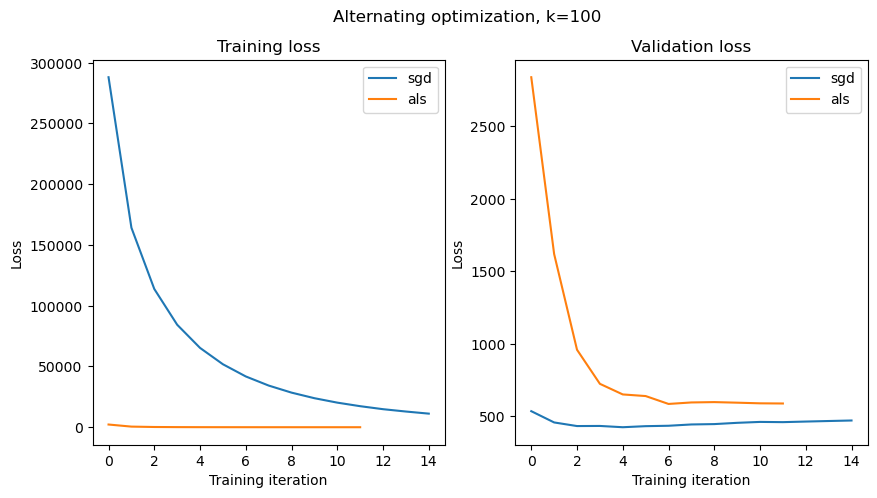

In [17]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
fig.suptitle("Alternating optimization, k=100")

ax[0].plot(train_loss_sgd[1::], label='sgd')
ax[0].plot(train_loss_als[1::], label='als')
ax[0].set_title('Training loss')
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()


ax[1].plot(val_loss_sgd[1::], label='sgd')
ax[1].plot(val_loss_als[1::], label='als')
ax[1].set_title('Validation loss')
ax[1].set_xlabel("Training iteration")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

# Autoencoder and t-SNE

Hereinafter, we will implement an autoencoder and analyze its latent space via interpolations and t-SNE. For this, we will use the famous Fashion-MNIST dataset.

In [25]:
from typing import List

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision
from torchvision.datasets import FashionMNIST
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

**Hint:** If you run into memory issues simply reduce the `batch_size`

In [26]:
train_dataset = FashionMNIST(root='data', download=True, train=True, transform=torchvision.transforms.ToTensor())
test_dataset = FashionMNIST(root='data', download=True, train=False, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, 
                                           num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, 
                                          num_workers=2, pin_memory=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 48.6MB/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 1.40MB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 24.2MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



### Task 4: Define decoder network

Feel free to choose any architecture you like. Our model was this:
```
Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
    (10): Sigmoid()
  )
)
```

In [32]:
class Autoencoder(nn.Module):
    ## BEGIN SOLUTION
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.01)
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, output_padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=16, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, stride=1),
            nn.Sigmoid()
        )
    ## END SOLUTION
    def forward(self, x):
        z = self.encode(x)
        x_approx = self.decode(z)
        
        assert x.shape == x_approx.shape
        return x_approx
    
print(Autoencoder())

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    

We see that our model transform the image from $28 \cdot 28 = 784$ dimensional space down into a $32 \cdot 3 \cdot 3 = 288$ dimensional space. However, note that the latent space also must contain some spatial information that the decoder needs for decoding.

In [33]:
x = test_dataset[0][0][None, ...]
z = Autoencoder().encode(x)

print(x.shape)
print(z.shape)
print(Autoencoder().decode(z).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 3, 3])
torch.Size([1, 1, 28, 28])


## Task 5: Train the autoencoder

Of course, we must train the autoencoder if we want to analyze it later on.

In [34]:
device = 0 if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) # weight_decay is the L2 regularization strength
scheduler = ExponentialLR(optimizer, gamma=0.999)

log_every_batch = 20

for epoch in range(50):
    model.train()
    train_loss_trace = []
    for batch, (x, _) in enumerate(train_loader):
        # TODO: The autoendocer shall be trained on the mse loss
        ## BEGIN SOLUTION
        x = x.to(device)
        optimizer.zero_grad()
        x_approx = model(x)
        loss = F.mse_loss(x_approx, x)  # use the mean squared error loss
        loss.backward()
        optimizer.step()

        ## END SOLUTION
        train_loss_trace.append(loss.detach().item())
        if batch % log_every_batch == 0:
            print(f'Training: Epoch {epoch} batch {batch} - loss {loss}')
    
    model.eval()
    test_loss_trace = []
    for batch, (x, _) in enumerate(test_loader):
        x = x.to(device)
        x_approx = model(x)
        loss = F.mse_loss(x_approx, x)
        test_loss_trace.append(loss.detach().item())
        if batch % log_every_batch == 0:
            print(f'Test: Epoch {epoch} batch {batch} loss {loss}')
    print(f'Epoch {epoch} finished - average train loss {np.mean(train_loss_trace)}, '
          f'average test loss {np.mean(test_loss_trace)}')

Training: Epoch 0 batch 0 - loss 0.16332513093948364
Training: Epoch 0 batch 20 - loss 0.07702259719371796
Training: Epoch 0 batch 40 - loss 0.046009503304958344
Test: Epoch 0 batch 0 loss 0.05424020066857338
Epoch 0 finished - average train loss 0.07444179316951056, average test loss 0.05377799160778522
Training: Epoch 1 batch 0 - loss 0.034740861505270004
Training: Epoch 1 batch 20 - loss 0.029188092797994614
Training: Epoch 1 batch 40 - loss 0.02634264901280403
Test: Epoch 1 batch 0 loss 0.024677013978362083
Epoch 1 finished - average train loss 0.02830266283225205, average test loss 0.024433193355798723
Training: Epoch 2 batch 0 - loss 0.02467944100499153
Training: Epoch 2 batch 20 - loss 0.023356642574071884
Training: Epoch 2 batch 40 - loss 0.021212579682469368
Test: Epoch 2 batch 0 loss 0.02174491062760353
Epoch 2 finished - average train loss 0.02257301497383643, average test loss 0.02153863701969385
Training: Epoch 3 batch 0 - loss 0.021204497665166855
Training: Epoch 3 batch 

KeyboardInterrupt: 

In [35]:
model.eval()
with torch.no_grad():
    latent = []
    for batch, (x, _) in enumerate(test_loader):
        latent.append(model.encode(x.to(device)).cpu())
    latent = torch.cat(latent)

## PCA and t-SNE (nothing to do here)
Next, we are going to look at some random images and their embeddings. Since 7x7 is still too large to visialize further dimensionality reduction techniques are required. 

It is not uncommand that a neural network designer wants to understand whats going on in the latent space and therefore uses techniques such as t-SNE.

In [36]:
def plot_latent(test_dataset: torch.utils.data.Dataset, z_test: torch.Tensor, count: int, 
                technique: str, perplexity: float = 30):
    """
    Fit t-SNE or PCA and plots the latent space. Moreover, we then display the correspeondig image.
    
    Parameters
    ----------
    test_dataset  : torch.utils.data.DataSet
                    Dataset containing raw images to display.
    z_test        : torch.Tensor
                    The transformed images.
    count         : int
                    Number of random images to sample
    technique     : str
                    Either "pca" or "tsne". Otherwise, a ValueError is thrown.
    perplexity    : float, optional, default: 30.0
                    Perplexity is t-SNE is used.
        
    """
    indices = np.random.choice(len(z_test), count, replace=False)
    inputs = z_test[indices]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2, perplexity=perplexity).fit_transform(inputs.reshape(count, -1))
    else:
        raise ValueError()

    for idx, (x, y) in zip(indices, coords):
        im = OffsetImage(test_dataset[idx][0].squeeze().numpy(), zoom=1, cmap='gray')
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(coords)
    ax.autoscale()
    plt.show()

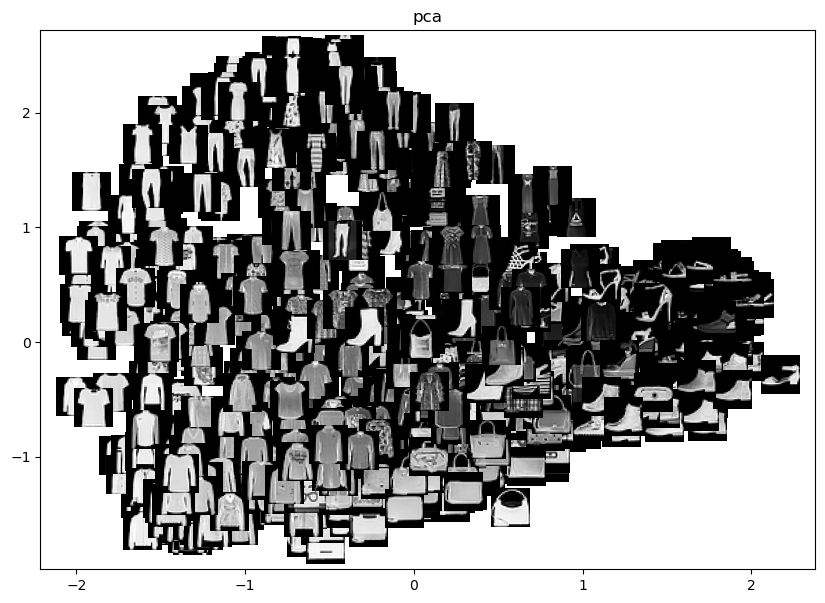

In [37]:
plot_latent(test_dataset, latent, 1000, 'pca')

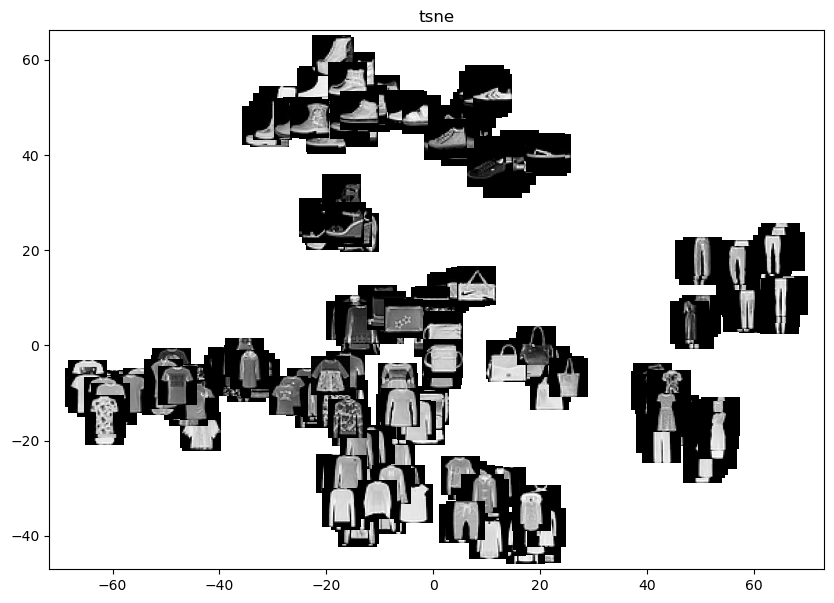

In [38]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=5)

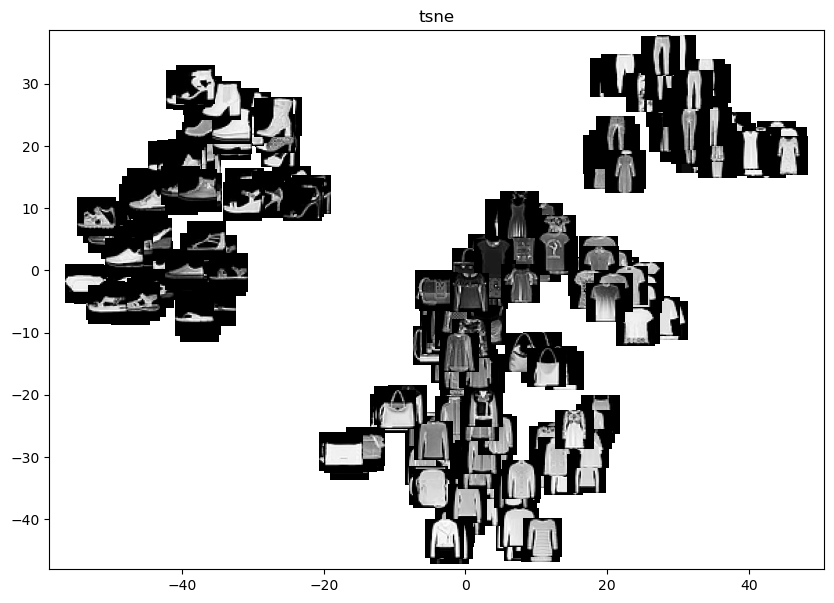

In [39]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=10)

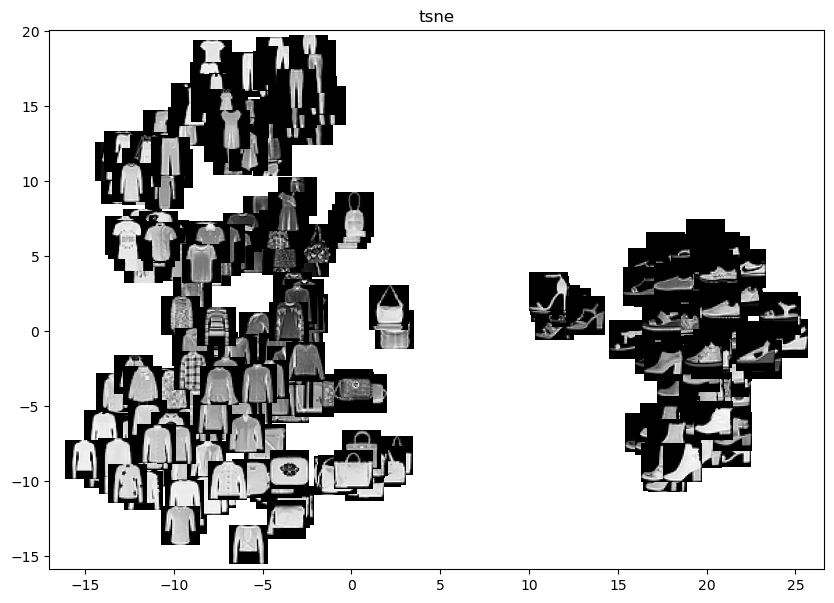

In [40]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=30)

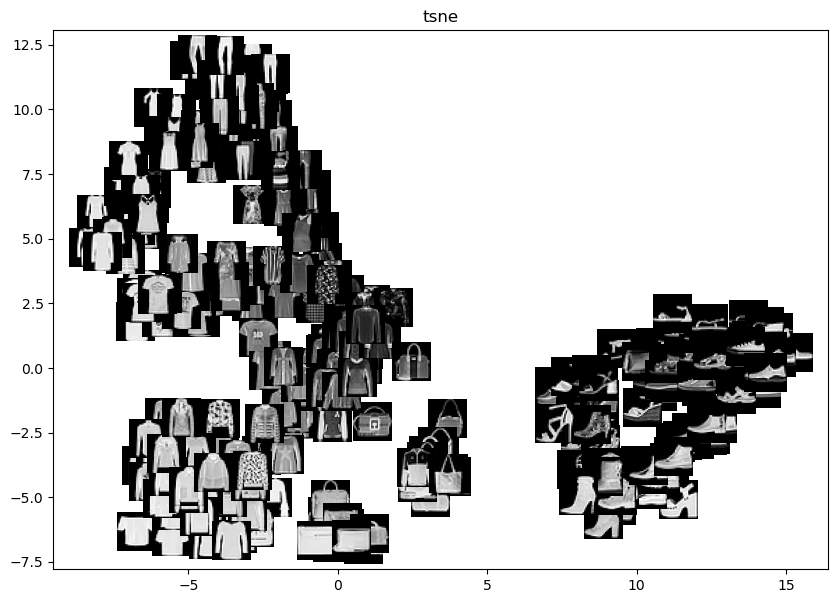

In [41]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=50)

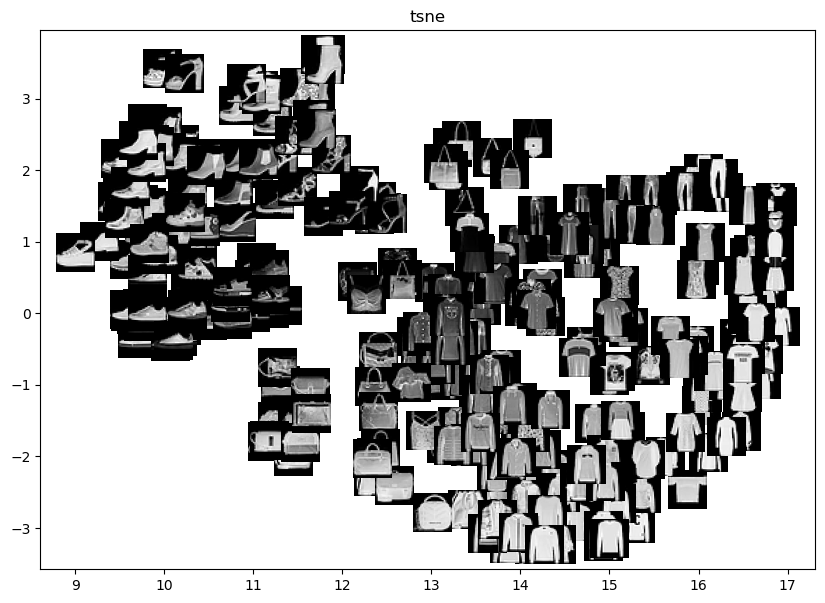

In [42]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=150)

## Task 6: Linear Interpolation on the latent space
If the latent space has learned something meanigfull, we can leverage this for further analysis/downstream tasks. Anyways, we were wondering all along how the interpolation between a shoe and a pullover might look like.

For this we encode two images $z_i = f_{enc}(x_i)$ and $z_j = f_{enc}(x_j)$. Then we linearily interpolate $k$ equidistant locations on the line between $z_i$ and $z_j$. Those locations are then be decooded by the decoder network $f_{dec}(\dots)$.

In [ ]:
def interpolate_between(model: Autoencoder, test_dataset: torch.utils.data.Dataset, idx_i: int, idx_j: int, n = 12):
    """
    Plot original images and the reconstruction of the linear interpolation in the respective latent space embedding.
    
    Parameters
    ----------
    model         : Autoencoder
                    The (trained) autoencoder.
    test_dataset  : torch.utils.data.Dataset
                    Test images.
    idx_i         : int
                    Id for first image.
    idx_j         : int
                    Id for second image.
    n             : n, optional, default: 1
                    Number of intermediate interoplations (including original reconstructions).
        
    """
    fig, ax = plt.subplots(1, 2, figsize=[6, 4])
    fig.suptitle("Original images")
    ax[0].imshow(test_dataset[idx_i][0][0].numpy(), cmap='gray')
    ax[1].imshow(test_dataset[idx_j][0][0].numpy(), cmap='gray')
    
    # Get embedding
    z_i = model.encode(test_dataset[idx_i][0].to(device)[None, ...])[0] # test_dataset[idx_i] returns a turple for example (image_tensor, label)
    z_j = model.encode(test_dataset[idx_j][0].to(device)[None, ...])[0] #None is used to add a batch dimension, [0] is to get the first sample
    
    fig, ax = plt.subplots(2, n//2, figsize=[15, 8])
    ax = [sub for row in ax for sub in row]
    fig.suptitle("Reconstruction after interpolation in latent space")

    with torch.no_grad():
        # TODO: Linearily interpolate between `z_i` and `z_j` in `n` equidistant steps. 
        # Then decode the embedding and plot the image and add the percentage as a title.
        ## BEGIN SOLUTION
        # Generate n equidistant interpolation factors between 0 and 1.
        alphas = np.linspace(0, 1, n)
        for i, alpha in enumerate(alphas):
            # this interpolation is to transform the latent representation of the images zi to a new latent representation zj
            z_interp = (1 - alpha) * z_i + alpha * z_j
            # Add a batch dimension for decoding (from shape [latent_dim] to [1, latent_dim])
            z_interp = z_interp.unsqueeze(0)
            # Decode the interpolated latent representation:
            x_recon = model.decode(z_interp)
            # remove the batch dimension
            img = x_recon[0].cpu().numpy().squeeze()
            # Plot the image and add the interpolation percentage as title
            ax[i].imshow(img, cmap='gray')
            ax[i].set_title(f"{alpha*100:.0f}%")
        ## END SOLUTION

    plt.show()

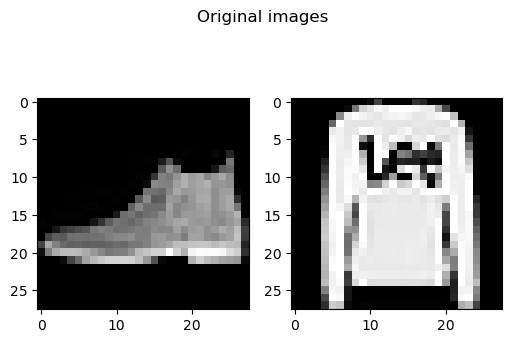

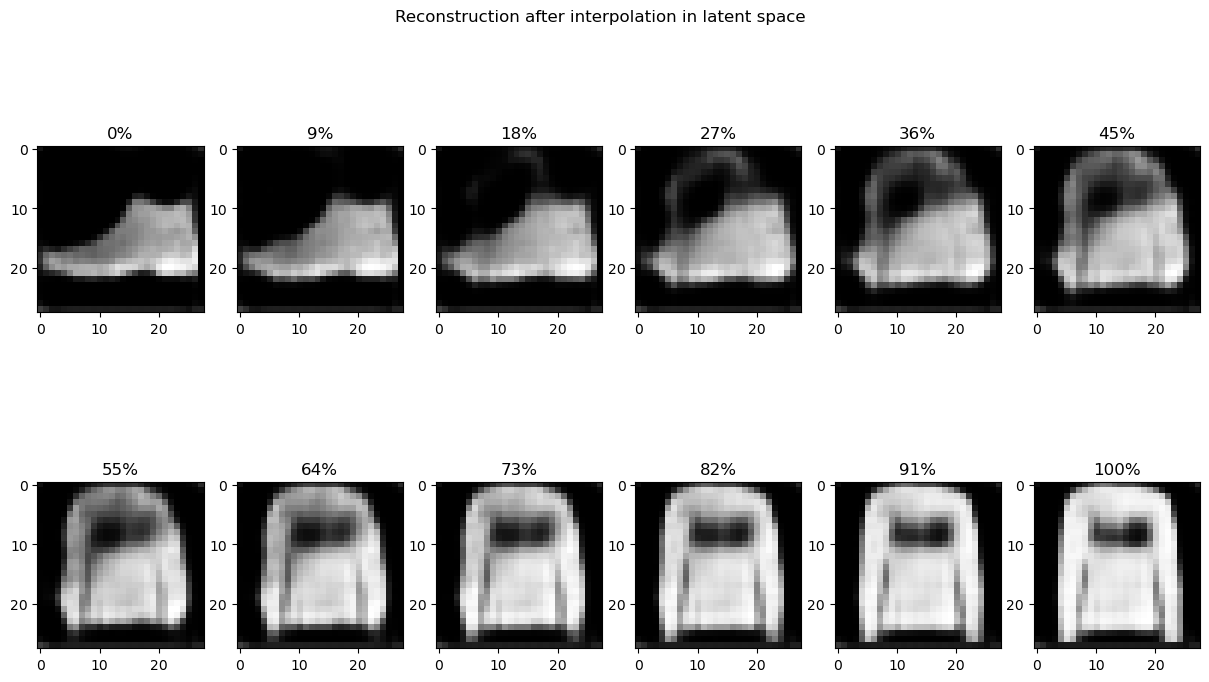

In [46]:
interpolate_between(model, test_dataset, 0, 1)

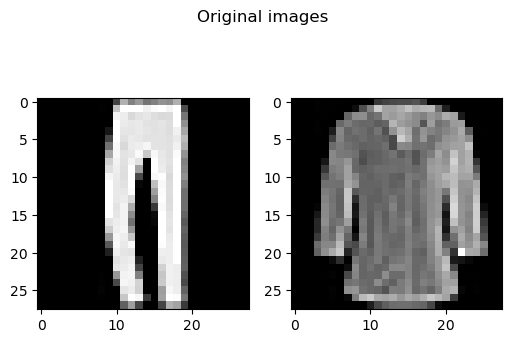

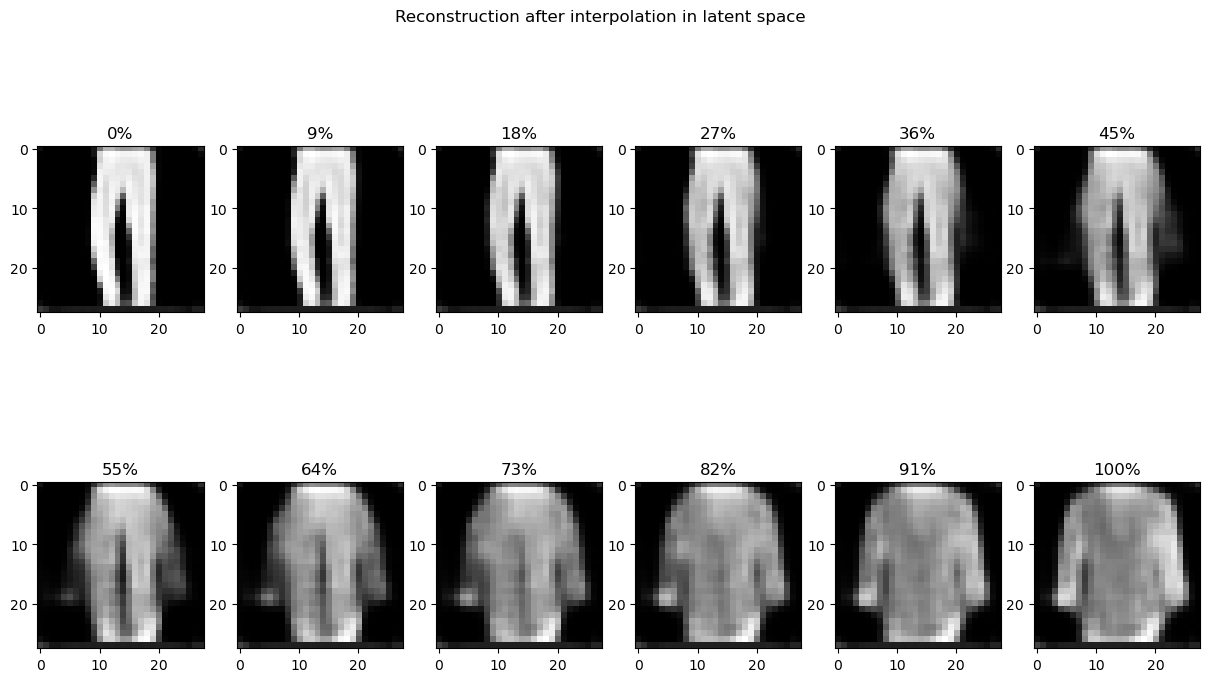

In [47]:
interpolate_between(model, test_dataset, 2, 4)

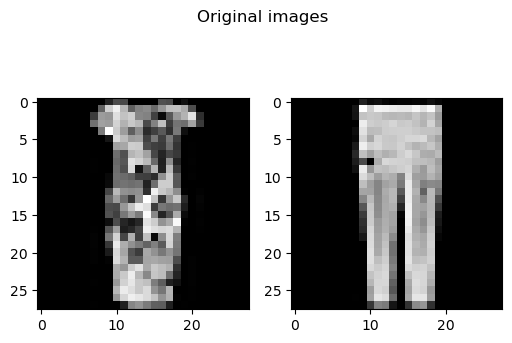

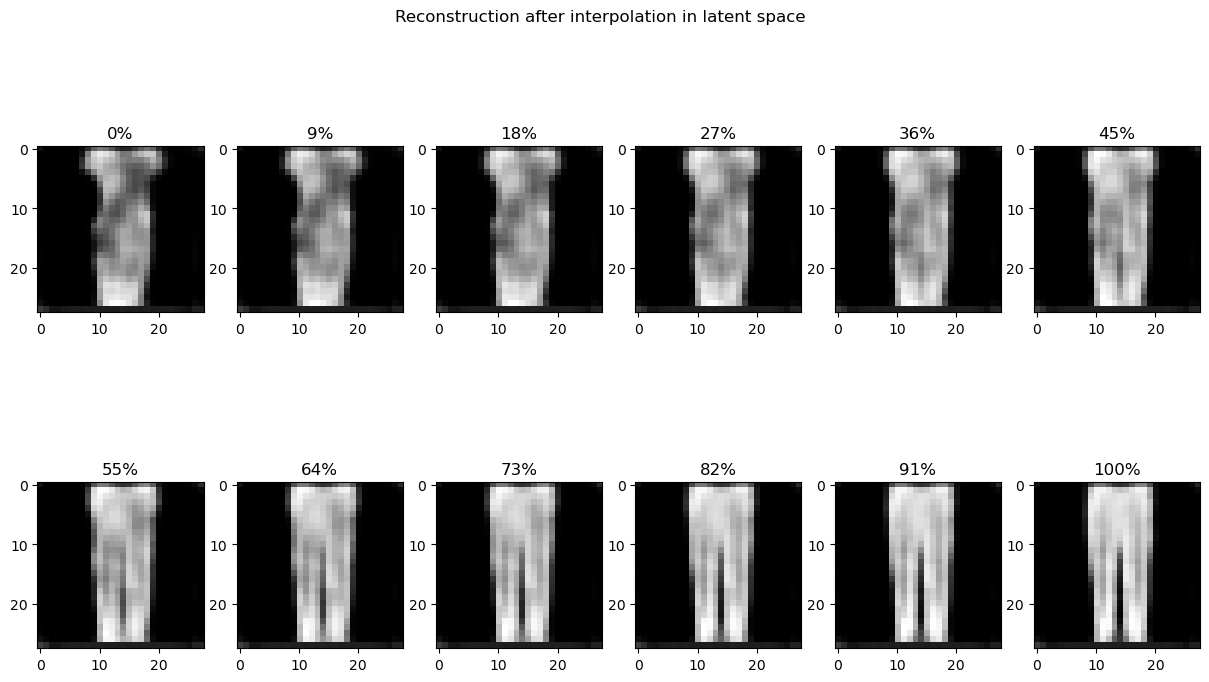

In [48]:
interpolate_between(model, test_dataset, 100, 200)